# Deep Learning for Drug-Target Interaction Prediction

### 0. Information About Datasets

Model evaluation is done on KIBA data-set. The original KIBA (**K**inase **I**nhibitor **B**io**A**ctivity) data set contains information about the binding affinities of 2111 drugs to 229 proteins.

**What do these affinity values mean?**

If the binding affinity of a drug to a protein is high, that means that the interaction between that protein and that drug is relatively stronger, hence we can say that the drug would be more effective against that protein. We tend to look for interactions with high binding affinities.

In order to be able to train our model faster, we reduced the KIBA dataset to just 111 proteins, 810 drugs and corresponding affinity values. We did this by selecting the drugs that are over 50 characters in sequence, and the proteins that are over 600 characters.

**Wait, how did we map proteins and drugs to sequences of characters?**

The process is different for proteins and drugs.



1.   **For Proteins:**
All proteins are made up of 20 amino acids, so we simply assign a character to each amino acid, and represent the protein(which is just a sequence of amino acids) as a sequence of characters. Note that this representation omits some key information about the proteins, most notably their structure. However, we can get good enough results even just by looking at the sequence information. There are studies out there, which also deal with the structure data by adding some extra information, but they are beyond the scope of this course.
2.   **For drugs:**
There is a way of representing molecules as a sequence of characters, called SMILES (**S**implified **M**olecular **I**nput-**L**ine **E**ntry **S**ystem). The details of this representation are beyond the scope of this course, but here are some examples of simple molecules and their SMILES representation:

  Vanilin (SMILES: O=Cc1ccc(O)c(OC)c1)

  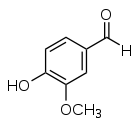

  Glucose (SMILES: OC\[C@@H](O1)\[C@@H](O)\[C@H](O)\[C@@H](O)\[C@H](O)1)

  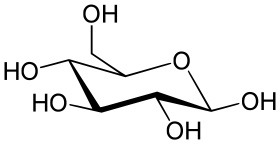






## Binding Affinity Prediction using Convolutional Neural Network (CNN) - Part 1

In this tutorial, we will implement a deep learning architecture to identify drug-target interactions' (DTI) strength (binding affinity) using character based sequence model. We will use PyTorch which is a deep learning library in Python.

The architecture is adopted from [DeepDTA](https://github.com/Sunitach10/MolPro)

In [1]:
# We will use some of the functions these libraries offer, so we have to 'import' them first.

# PyTorch: Contains functions that help us simplify the deep learning process.
# With PyTorch, we can build a neural newtork, split our data into train & test sets, and train our model with the data with just a few lines of code.
import torch

# JSON(JavaScript Object Notation) is a commonly used format to transfer data in an organized manner.
# We have to use that library here to load drug and protein data, because they are stored in JSON format in the databases we use.
import json

# NumPy lets us do numerical manipulation and linear algebra on arrays in a very simple way. It is essentially MATLAB functions for Python.
import numpy as np

# Pickle is a Python-specific way of converting objects (such as classes, data structures etc.) into byte streams.
# Just like JSON, we use pickle to retrieve drug-related data (in this case, affinity data) from the databases.
import pickle

# We can import specific modules and functions from libraries, and rename them for convenience.
# That way, instead of writing torch.nn.(...) each time we add a neural network layer (which tends to happen a lot in the code), we can simply write nn.(...)
import torch.nn as nn

# Same principle is applied with a different module. This one contains several functions that are commonly used in the deep learning process, such as the loss functions.
import torch.nn.functional as F

# This module helps us convert the data we download from the dataset (via either JSON or pickle) into a PyTorch-readable format.
from torch.utils.data import Dataset

# This module samples elements randomly from a given list of indices, without replacement. Getting a random & unique sample of data helps us in the training process.
from torch.utils.data.sampler import SubsetRandomSampler

# This library is used to generate random numbers.
import random

# This module contains various optimization algorithms, such as Adam and SGD.
from torch import optim

# This module helps the model to 'load' the data. We use it instead of iterating over the data ourselves to simplify the process.
from torch.utils.data import DataLoader

# This library allows us to send HTTP requests easily. Essentialy, it allows us to navigate a website in code.
import requests

# This library allows us to create new folders, search existing folders, and change our current working folder.
import os

# This library allows us to manipulate and visualise datasets. You can think of it as Excel for Python.
import pandas as pd

### 1. Prepare Dataset

***Data Input representation to the model:***

We will apply one-hot encoding that uses binary integers (0, 1) for the drug and protein to represent inputs. Both SMILES (length<50) and protein sequences (length<600) have varying lengths. Hence, in order to create an effective representation form (one-hot encoding), we decided to fixed maximum lengths of 50(characters) for SMILES and 600(characters) for protein sequences in our data-set. Final one-hot representation of drugs and proteins having dimension of (62x50) and (25x600) respectively. Here 62 and 25 are unique characters from SMILES (drug) and proteins respectively.

In [2]:
# These are the encodings for 20(+5 for ???) amino acids
protein_encode = {"A": 1, "C": 2, "B": 3, "E": 4, "D": 5, "G": 6,
            "F": 7, "I": 8, "H": 9, "K": 10, "M": 11, "L": 12,
            "O": 13, "N": 14, "Q": 15, "P": 16, "S": 17, "R": 18,
            "U": 19, "T": 20, "W": 21,
            "V": 22, "Y": 23, "X": 24,
            "Z": 25}

# These are the encodings for SMILES strings.
drug_encode = {"#": 1, "%": 2, ")": 3, "(": 4, "+": 5, "-": 6,
           ".": 7, "1": 8, "0": 9, "3": 10, "2": 11, "5": 12,
           "4": 13, "7": 14, "6": 15, "9": 16, "8": 17, "=": 18,
           "A": 19, "C": 20, "B": 21, "E": 22, "D": 23, "G": 24,
           "F": 25, "I": 26, "H": 27, "K": 28, "M": 29, "L": 30,
           "O": 31, "N": 32, "P": 33, "S": 34, "R": 35, "U": 36,
           "T": 37, "W": 38, "V": 39, "Y": 40, "[": 41, "Z": 42,
           "]": 43, "_": 44, "a": 45, "c": 46, "b": 47, "e": 48,
           "d": 49, "g": 50, "f": 51, "i": 52, "h": 53, "m": 54,
           "l": 55, "o": 56, "n": 57, "s": 58, "r": 59, "u": 60,
           "t": 61, "y": 62}

In [3]:
def DTIpair(mol, pro, y):
    """
    Converts a set of molecule and protein data into PyTorch tensors, and stores them with the affinity score associated with that pair.

    Parameters
    ----------
    mol : dict
    A dictionary where the keys are integers, and values are corresponding molecule data.
    pro : dict
    A dictionary where the keys are integers, and values are corresponding protein data.
    y : list
    A 2D list that contains the affinity scores for each protein-drug pair. The keys of 'mol' and 'pro' correspond to the indices of y.

    Returns
    -------
    mol_pro : list
    A list of tuples. Each tuple has 3 elements, and this structure: (molecule, protein, affinity_score)
    """
    mol_pro = []
    for i, m in mol.items():
        for j, p in pro.items():
            mol_pro.append(((torch.Tensor(m),torch.Tensor(p)),y[i][j]))
    return mol_pro

In [4]:
def onehot(sent, charset, lens_m):
    """
    When feeding data to a deep learning model, it's more practical to work with a "one-hot" encoded version of the data, rather than raw data itself.
    One-hot encoding converts a character, or an integer, into an array which has the value "1" in a specific location corresponding to the character (or the integer), and 0 elsewhere.
    For example, if we know that our dataset consists of numbers between 1 and 10, we can encode 5 as:

        ⎡ 0 ⎤
        ⎢ 0 ⎥
        ⎢ 0 ⎥
        ⎢ 0 ⎥
    5 =   ⎢ 1 ⎥
        ⎢ 0 ⎥
        ⎢ 0 ⎥
        ⎢ 0 ⎥
        ⎢ 0 ⎥
        ⎣ 0 ⎦

    or, 9 as:

        ⎡ 0 ⎤
        ⎢ 0 ⎥
        ⎢ 0 ⎥
        ⎢ 0 ⎥
    9 =   ⎢ 0 ⎥
        ⎢ 0 ⎥
        ⎢ 0 ⎥
        ⎢ 0 ⎥
        ⎢ 1 ⎥
        ⎣ 0 ⎦

    What we do is essentially create a 1-to-1 mapping from values in a set of length n to a set of (1xn) one-hot vectors.

    This function takes a list of character sets, and creates a list of one-hot encodings for each character set.

    Parameters
    ----------
    sent : dict
    A dictionary with integers as keys (these are used as indices), and strings (sets of characters) as values.
    charset : dict
    A dictionary with characters as keys, and integers as values. See "protein_encode" as an example.
    lens_m : int
    The maximum number of characters each string can possibly have. All one-hot vector arrays are created in a fixed size, no matter what their actual length is.

    Returns
    -------
    onex_d : dict
    A dictionary with integers as keys (these are the same indices as in "sent"), and arrays of one-hot vectors as values.
    """
    onex_d = {}
    char_to_int = dict((c, i) for i, c in enumerate(list(charset.keys())))
    int_to_char = dict((i, c) for i, c in enumerate(list(charset.keys())))
    for i, s in sent.items():
        onehot_sent = np.zeros((len(char_to_int), lens_m))
        for j, char in enumerate(s):
            onehot_sent[char_to_int[char], j] = 1.0
        onex_d[i] = onehot_sent
    return onex_d

In [5]:
def filter(x, l):
    """
    This function takes a list of strings, and discards the ones that are larger than the specified length.

    Parameters
    ----------
    x : dict
    A dictionary with integers as keys, and strings as values.
    l : int
    Maximum string length allowed

    Returns
    -------
    pt : dict
     A dictionary with integers as keys, and filtered strings as values. All the values have a length smaller than or equal to "l" now.
    """
    pt = {}
    for i, p in enumerate(x.values()):
        if i < 2:
            print(x)
        if len(p) <= l:
            pt[i] = p
    return pt

In [6]:
class Dataset(Dataset):
    """
    A class used to represent a PyTorch-readable dataset.

    Methods
    -------
    __len__()
    Returns the size of the dataset.

    __getitem__(idx)
    Returns the item at index : idx.
    """
    def __init__(self, drug_path, protein_path, affinity_path):
        """
        Parameters
        ----------
        drug_path : str
          File path of the drug database.
        protein_path : str
          File path of the protein database.
        affinity_path : str
          File path of the table containing affinity scores.
        """
        with open(drug_path) as drug_data:
            self.drugs = onehot(filter(json.load(drug_data), 50), drug_encode, 50)
        with open(protein_path) as protein_data:
            self.proteins = onehot(filter(json.load(protein_data), 600), protein_encode, 600)
        with open(affinity_path, 'rb') as Y:
            y1 = pickle.load(Y, encoding='latin1')
        self.y = torch.Tensor(np.nan_to_num(y1))

        self.mol_pro = DTIpair(self.drugs, self.proteins, self.y)

    def __len__(self):
        return len(self.mol_pro)

    def __getitem__(self, idx):
        """
        Parameters
        ----------
        idx : int
          The desired index.
        """
        return self.mol_pro[idx]

In [7]:
def load_split_set(dataset, test_split):
    """
    Splits the dataset into train & test datasets. However, instead of physically separating the dataset into 2 parts,
    PyTorch randomly partitions the list of indices into 2 disjoint sets (not Python sets, sets in general sense),
    and then gives these index lists to 2 separate Sampler objects so that they can randomly sample from them.
    Then, these Sampler objects are added to DataLoader objects, which iterate over the datasets at given indices, while also optionally bundling them into mini batches.

    Parameters
    ----------
    dataset : Dataset
    An instance of the Dataset class that contains our data.
    test_split : int
    The desired ratio of splitting. test_split*dataset_size elements go to train set, the rest go to test set.

    Returns
    -------
    train_loader : torch.utils.data.DataLoader
    A DataLoader object for the training potrion of the dataset.
    test_loader : torch.utils.data.DataLoader
    A DataLoader object for the testing potrion of the dataset.
    """
    shuffle_dataset = True
    random_seed= 42
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(test_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, test_indices = indices[split:], indices[:split]

    # Creating data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=4,
                                          sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                              sampler=test_sampler)
    return train_loader,test_loader

### 2. Model

In this tutorial, we aim to predict the binding affinity scores and use Convolutional Neural Network (CNN). Prediction model comprises two separate CNN blocks, each of which aims to learn representations from SMILES strings and protein sequences separately. For each CNN block the number of filters is 16 in first and 32 in the second convolutional layer then followed by the max-pooling layer. The final features of the max-pooling layers are concatenated and fed into two FC layers with a dropout layer (rate=0.15).

- Activation function used: Rectified Linear Unit (ReLU).
- Loss function used: Root mean squared error (RMSE).

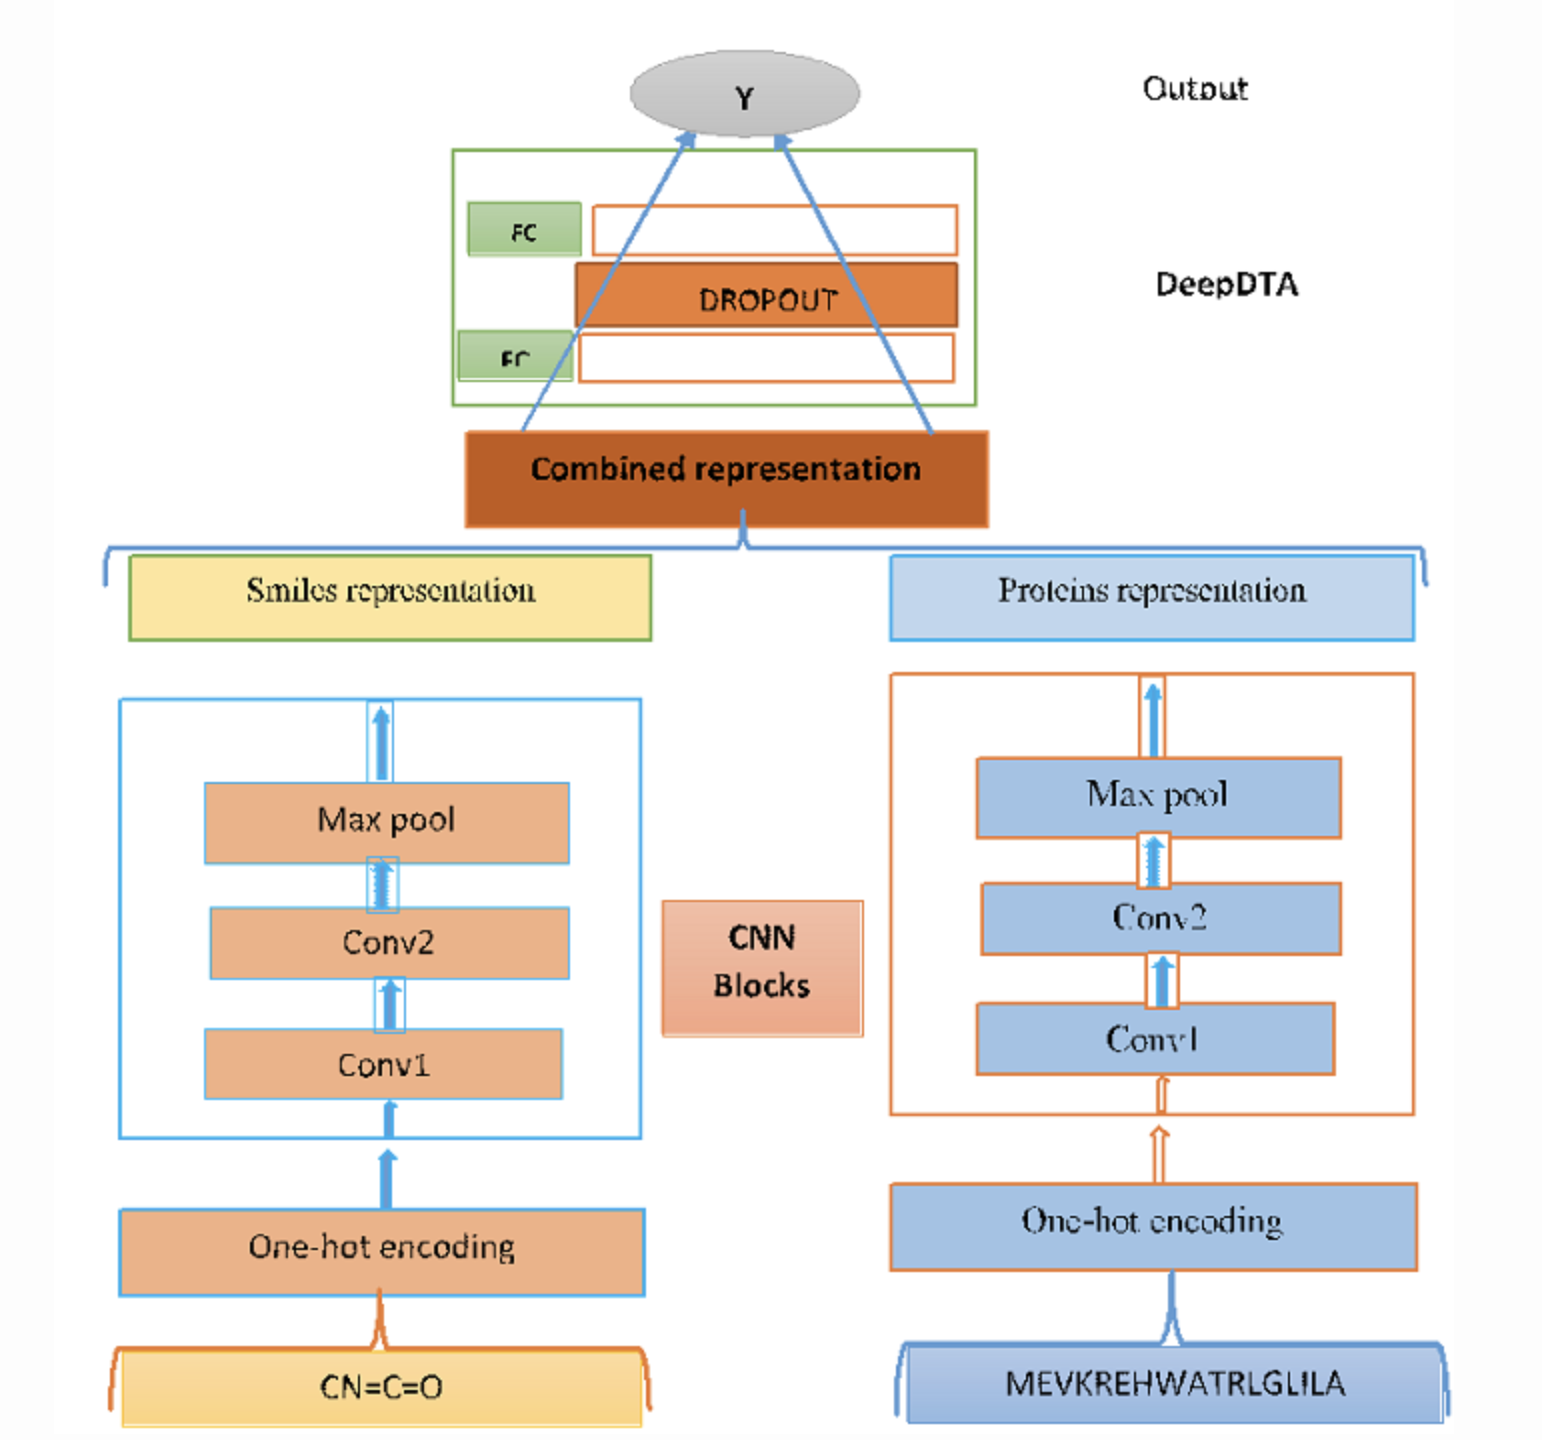

In [8]:
class CNN(nn.Module):
    """
    A class used to create a CNN capable of learning on protein & drug data.
    In this example, the parameters of the network are chosen to accomodate the dimensions of the data we have,
    but you can use this code as a template and change the parameters to train on any dataset you want.
    """
    def __init__(self):
        """
        Like making a cake, this function creates a neural network layer by layer.
        As long as the out_channels of each layer (except the final one) is the same as the in_channels of the next layer, you're free to add as many layers as you want.
        We're using 1D convolutional layers, because our data is one-dimensional. If we were to train our models on, say, images, we would have to use 2D convoluional layers.
        The max pooling layer is (in general) added to the end of convolutional layers to increase the translational invariance of the model.
        In images, this helps the model to recognize features when they are scaled, moved, or rotated.
        In proteins, it helps find common patterns even if they are in different positions in different proteins.
        Dropout layer is added to prevent the model from simply memorizing the examples, and to push it to learn the underlying patterns in them.
        Both pooling and dropout are commonly used in CNNs. The technical details are beyond the scope of this tutorial, but you're free to look them up.
        In addition to those layers, 2 final linear layers are applied to the combined results from drug CNN and protein CNN to create a single, float output.
        """
        super(CNN, self).__init__()
        # for smiles
        self.sconv1 = nn.Conv1d(in_channels=62, out_channels=16, kernel_size=2, stride=1, padding=1)
        self.sconv2 = nn.Conv1d(16, 32, 2, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2, 2)

        #for proteins
        self.pconv1 = nn.Conv1d(in_channels=25, out_channels=16, kernel_size=2, stride=1, padding=1)
        self.pconv2 = nn.Conv1d(16, 32, 2, stride=1, padding=1)

        self.dropout = nn.Dropout(0.15)
        self.linear1 = nn.Linear(5216, 256)
        self.linear2 = nn.Linear(256, 1)

    def forward(self, x, x1):
        x = self.pool(F.relu(self.sconv1(x)))
        x = self.pool(F.relu(self.sconv2(x)))

        x1 = self.pool(F.relu(self.pconv1(x1)))
        x1 = self.pool(F.relu(self.pconv2(x1)))

        x = x.view(-1, 13*32)
        x1 = x1.view(-1,150*32)

        x2 = torch.cat([x, x1],1)
        x2 = F.relu(self.linear1(x2))
        x2 = self.dropout(x2)
        x2 = self.linear2(x2)
        return x2

### 3. Train

For training and loss calculation we use Adam optimizer and RMSE loss function respectively.

In [9]:
class rms_loss(nn.Module):
    """
    This calculates the Root Mean Square loss between a given pair of vectors. nn.MSELoss() is a function that takes in two vectors, and returns the RMS loss.
    """
    def __init__(self):
        super().__init__()
        self.mse=nn.MSELoss()
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [10]:
def train(model,train, num_epochs = 10, lr=0.003):
    """
    This function combines everything we introduced in the previous code blocks.
    When a model and a training dataset are given, it applies the model to the data points, gets a result, compares it with the actual result,
    and updates the model based on that information.

    Parameters
    ----------
    model : torch.nn.Module
    The model we created for training. In this example, we created a CNN with 2 separate convolutional + 1 separate linear layers for the protein and the drug.
    train : torch.utils.data.DataLoader
    Training data, in DataLoader format. We introduced the necessary functions to convert raw data into this format in the above code blocks.
    num_epochs : int(default : 10)
    The number of times we want our model to traverse the entire train dataset. In general, the accuracy of the model converges to a certain value after a certain number of epochs.
    lr : float(default : 0.003)
    The rate at which we want our model to make small nudges on its parameters. There is an optimal learning rate for each model and data:
    keep it too high and your parameters don't converge to their optimal values, keep it too low, and it takes a very long time to get there.

    Returns
    -------
    loss : list
    The results of rms_loss.forward() for the model & train data.
    out1 : list
    The model outputs for each data point in each epoch.
    """
    criterion = rms_loss()
    optimizer=optim.Adam(model.parameters(), lr)
    for epoch in range(num_epochs):
        r_loss = 0
        loss1 = []
        out1 = []
        count = 0
        for i, j in (train):
            m=i[0]
            m = m.reshape((4, 62, 50))
            p=i[1]
            p = p.reshape((4, 25, 600))
            output = model(m, p)
            out1.append(output)
            loss = criterion(output, j)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss1.append(loss)
            count += 1
            if count == 50:
                print("Epoch #", (epoch+1), " Loss: ", loss.item())
                break
    return loss1,out1

In [11]:
drug_path = "data/drugs.txt"
target_path = "data/proteins.txt"
affinity_path = "data/affinity"
dataset = Dataset(drug_path, target_path, affinity_path)
train_loader, test_loader = load_split_set(dataset, .2)
model = CNN()
tt = train(model,train_loader)

{'CHEMBL1087421': 'COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl', 'CHEMBL1088633': 'COC1=C(C=C2C(=C1)CCN=C2C3=CC(=CC=C3)Cl)Cl', 'CHEMBL1090360': 'C1COCCN1C2=CC(=CC=C2)NC3=NC=CC(=N3)C4=C(N=C5N4C=CS5)C6=CC(=CC=C6)NC(=O)CC7=CC=CC=C7', 'CHEMBL1688215': 'C1=CC2=C(C=C1C3=NC(=NC=C3)N)NN=C2N', 'CHEMBL1765781': 'CNC1=NC(=CN=C1)C2=CNC(=O)C(=C2)NC(=O)C3=CC=C(C=C3)N4CCCC4CN5CCCC5', 'CHEMBL1788116': 'C1=CC=C2C(=C1)NC(=C(C#N)C3=NC(=NC=C3)NCCC4=CN=CC=C4)S2.C(=O)(C(F)(F)F)O.C(=O)(C(F)(F)F)O', 'CHEMBL1929238': 'CC(C)(C)C1=CC(=C(S1)NC(=O)NC2=C(C(=CC=C2)Cl)Cl)C(=O)N3CCC(=O)N(CC3)CCN(C)C', 'CHEMBL1933552': 'CC1CCC(CN1)N2CCC3(C2)CN(C4=CC=CC=C34)C(=O)C5=CC6=C(N5)C=C(C=C6)F', 'CHEMBL202930': 'COC1=C(C=CC(=C1)C2=CC3=C(C=C2)C(=CC4=CC=CN4)C(=O)N3)O', 'CHEMBL204420': 'CN1CCN(C(C1)C(=O)N)CC2=C(C=C3C(=C2)C(=NC=N3)NC4=C(C(=CC=C4)Cl)F)OC', 'CHEMBL206783': 'COC1=C(C=C2C(=C1)N=CN=C2NC3=C(C(=CC=C3)Cl)F)CN4CCCCC4C(=O)N', 'CHEMBL206955': 'COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)CN4CCCC4C(=O)N', 'CHEMBL207037': 'COC1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch # 1  Loss:  8.328611373901367
Epoch # 2  Loss:  8.699442863464355
Epoch # 3  Loss:  0.05684845894575119
Epoch # 4  Loss:  5.418210983276367
Epoch # 5  Loss:  0.48324546217918396
Epoch # 6  Loss:  0.18597495555877686
Epoch # 7  Loss:  0.13058048486709595
Epoch # 8  Loss:  6.08896541595459
Epoch # 9  Loss:  0.2807258665561676
Epoch # 10  Loss:  5.939947128295898


### 4. Predict

In [12]:
def predict(model,test):
    """
    This function applies the (now trained) model to our test dataset. This way, we can see how well the model performs with a dataset it has never seen before,
    which gives very important results about its usefulness.

    Parameters
    ----------
    model : torch.nn.Module
    Our trained model.
    test : torch.utils.data.DataLoader
    Our test dataset.

    Returns
    -------
    out : list
    The output of the model for each data point at each epoch.
    """
    out = []
    count = 0
    for i,j in(test):
        d = i[0]
        d = d.reshape((1, 62, 50))
        p = i[1]
        p = p.reshape((1, 25, 600))
        predict = model(d, p)
        out.append((d, p, predict))
        count += 1
        if count == 50:
            break
    return out

In [13]:
def decode(drug_tensor, target_tensor):
    """
    This function decodes the given drug and target protein and returns the SMILE representation and the protein sequence.

    Parameters
    ----------
    drug_tensor : torch.Tensor
    One hot encoded drug.
    target_tensor : torch.Tensor
    One hot encoded target protein.

    Returns
    -------
    drug_str : str
    The SMILE representation of the given drug.
    target_str : str
    The sequence of the given target protein.
    """
    int_to_char_drug = dict((i, c) for i, c in enumerate(list(drug_encode.keys())))
    int_to_char_target = dict((i, c) for i, c in enumerate(list(protein_encode.keys())))
    drug = torch.transpose(drug_tensor, 0, 1).tolist()
    drug_str = ""
    for i, e in enumerate(drug):
        try:
            ind = e.index(float(1))
            drug_str += int_to_char_drug[ind]
        except:
            pass
    target = torch.transpose(target_tensor, 0, 1).tolist()
    target_str = ""
    for i, e in enumerate(target):
        try:
            ind = e.index(float(1))
            target_str += int_to_char_target[ind]
        except:
            pass
    return drug_str, target_str

In [14]:
pred = predict(model,test_loader)
test_lst = list()
for d, t, s in pred:
    drug, target = decode(d[0], t[0])
    print("Drug: ", drug)
    print("Target: ", target)
    print("Prediction score: ", s.item())
    print()

Drug:  CC(C(C)(C)C)NC1=C(C(=O)C1=O)N(C2=CC=NC=C2)C(=O)C
Target:  MAVPFVEDWDLVQTLGEGAYGEVQLAVNRVTEEAVAVKIVDMKRAVDCPENIKKEICINKMLNHENVVKFYGHRREGNIQYLFLEYCSGGELFDRIEPDIGMPEPDAQRFFHQLMAGVVYLHGIGITHRDIKPENLLLDERDNLKISDFGLATVFRYNNRERLLNKMCGTLPYVAPELLKRREFHAEPVDVWSCGIVLTAMLAGELPWDQPSDSCQEYSDWKEKKTYLNPWKKIDSAPLALLHKILVENPSARITIPDIKKDRWYNKPLKKGAKRPRVTSGGVSESPSGFSKHIQSNLDFSPVNSASSEENVKYSSSQPEPRTGLSLWDTSPSYIDKLVQGISFSQPTCPDHMLLNSQLLGTPGSSQNPWQRLVKRMTRFFTKLDADKSYQCLKETCEKLGYQWKKSCMNQVTISTTDRRNNKLIFKVNLLEMDDKILVDFRLSKGDGLEFKRHFLKIKGKLIDIVSSQKIWLPAT
Prediction score:  4.754786491394043

Drug:  C1CCC(C(C1)N)NC2=NC=CC(=N2)C3=CNC4=C3C=CC=N4
Target:  MAAAAAQGGGGGEPRRTEGVGPGVPGEVEMVKGQPFDVGPRYTQLQYIGEGAYGMVSSAYDHVRKTRVAIKKISPFEHQTYCQRTLREIQILLRFRHENVIGIRDILRASTLEAMRDVYIVQDLMETDLYKLLKSQQLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLINTTCDLKICDFGLARIADPEHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINMKARNYLQSLPSKTKVAWAKLFPKSDSKALDLLDRMLTFNPNKRITVEEALAHPYLEQYYDPTDEPVAEEPFTFAMELDDLPKER

## Drug Repurposing using Deep Purpose - Part 2

In this part, we will train a model to predict best drug candidates for the severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2).

SARS-CoV-2 uses an RNA-dependent RNA polymerase (RdRp) for the replication of its genome and the transcription of its genes [1]. Therefore, RdRp is how the virus replicates once it has access to a cell's machinery. Preventing the replication of genome stops the production of new viruses. RdRp is one of the main targets in SARS-CoV-2 for drugs, to prevenet the further progression and spread of the disease once a patient is infected.

We will use the same dataset as before, which includes kinases and kinase inhibitors. Then, we will run a prediction for antiviral drug candidates to find potential drug canditates that may inhibit SARS-CoV-2 RNA-dependent RNA-polymerase. We will be using DeepPurpose, which is a Deep Learning based Drug Repurposing and Virtual Screening Toolkit that uses PyTorch. [2] It enables us to use more advanced deep learning models with a few lines of code.

---

[1] Maio N, Lafont BAP, Sil D, Li Y, Bollinger JM Jr, Krebs C, Pierson TC, Linehan WM, Rouault TA. Fe-S cofactors in the SARS-CoV-2 RNA-dependent RNA polymerase are potential antiviral targets. *Science*. 2021

[2] Huang, K., Fu, T., Glass, L. M., Zitnik, M., Xiao, C., & Sun, J. (2020). DeepPurpose: a deep learning library for drug–target interaction prediction. *Bioinformatics*, 36(22-23), 5545-5547.

### Setup Environment

In [15]:
!pip install rdkit-pypi subword_nmt wget pandas-flavor lifelines py3Dmol
!pip install git+https://github.com/bp-kelley/descriptastorus
!pip install prettytable

  Cloning https://github.com/bp-kelley/descriptastorus to /private/var/folders/6m/ym42hd6n4kx412b404vstsv00000gn/T/pip-req-build-h41zc6vt
  Running command git clone --filter=blob:none --quiet https://github.com/bp-kelley/descriptastorus /private/var/folders/6m/ym42hd6n4kx412b404vstsv00000gn/T/pip-req-build-h41zc6vt
  Resolved https://github.com/bp-kelley/descriptastorus to commit 9a190343bcd3cfd35142d378d952613bcac40797
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [16]:
!pip install py3Dmol

### Imports

In [17]:
# DeepPurpose is a deep learning based drug repurposing library (hence the name). 
# These imports contain the functions we will use throughout this tutorial.
# This might show some warnings, simply ingore them.

from DeepPurpose import utils, dataset
from DeepPurpose import DTI as models
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

In [18]:
# RDKit is a chemoinformatics and machine learning library. 
# These imports also contain the functions that we will use in the rest of the tutorial.
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
# This library is used to display a molecule in 3D.
import py3Dmol
# These 2 are display options.
IPythonConsole.ipython_useSVG=False
IPythonConsole.molSize = 400, 400

### Model Training and Prediction

We are going to use the same dataset you used in the first part, KIBA [1]. But, this time we have a one-liner, which is a single line of code, to load and process the data included in this dataset.

* path = Where to download the dataset?
* binary = Is the prediction task binary classification or regression?


---


[1] https://researchportal.helsinki.fi/fi/datasets/kiba-a-benchmark-dataset-for-drug-target-prediction



In [21]:
# We load the KIBA dataset with this function.
# X_drugs is a list of drugs in SMILES format.
# X_targets is a list of proteins, stored as strings of amino acids.
# y is the list of affinity values for each drug and target.
X_drugs, X_targets, y = dataset.load_process_KIBA(path = 'data', binary = False)

print('Example Drug: ' + X_drugs[0])
print('Example Target: ' + X_targets[0])
print('Example y: ' + str(y[0]))

Beginning Processing...
Beginning to extract zip file...
Done!
Example Drug: COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl
Example Target: MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNSYACKHPEVQSILKISQPQEPELMNANPSPPPSPSQQINLGPSSNPHAKPSDFHFLKVIGKGSFGKVLLARHKAEEVFYAVKVLQKKAILKKKEEKHIMSERNVLLKNVKHPFLVGLHFSFQTADKLYFVLDYINGGELFYHLQRERCFLEPRARFYAAEIASALGYLHSLNIVYRDLKPENILLDSQGHIVLTDFGLCKENIEHNSTTSTFCGTPEYLAPEVLHKQPYDRTVDWWCLGAVLYEMLYGLPPFYSRNTAEMYDNILNKPLQLKPNITNSARHLLEGLLQKDRTKRLGAKDDFMEIKSHVFFSLINWDDLINKKITPPFNPNVSGPNDLRHFDPEFTEEPVPNSIGKSPDSVLVTASVKEAAEAFLGFSYAPPTDSFL
Example y: 11.1


We will use two different encoding methods for the encoding of drugs and targets. As shown before, drugs are represented with SMILES, and targets are represented with their aminoacid sequences. For more efficient learning from these representation, we need to encode these data. We will use a *Message Passing Neural Network* (MPNN) for encoding drugs, and a *Conjoint Triad* (CT) for encoding targets. There are also other different encoding methods available, depending on the data and the use case.

**Message Passing Neural Network (MPNN)**

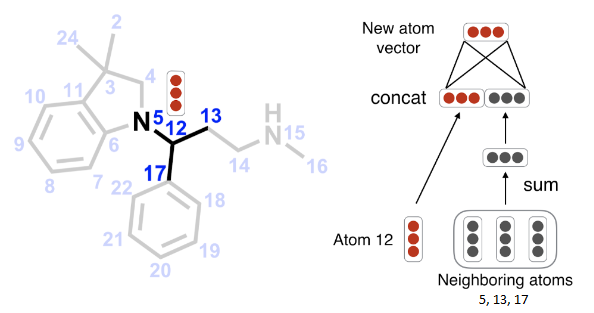

---

UFZ Department of Ecological Chemistry 2019. ChemProp 6.7.1
http://www.ufz.de/ecochem/chemprop

**Conjoint Triad (CT)**

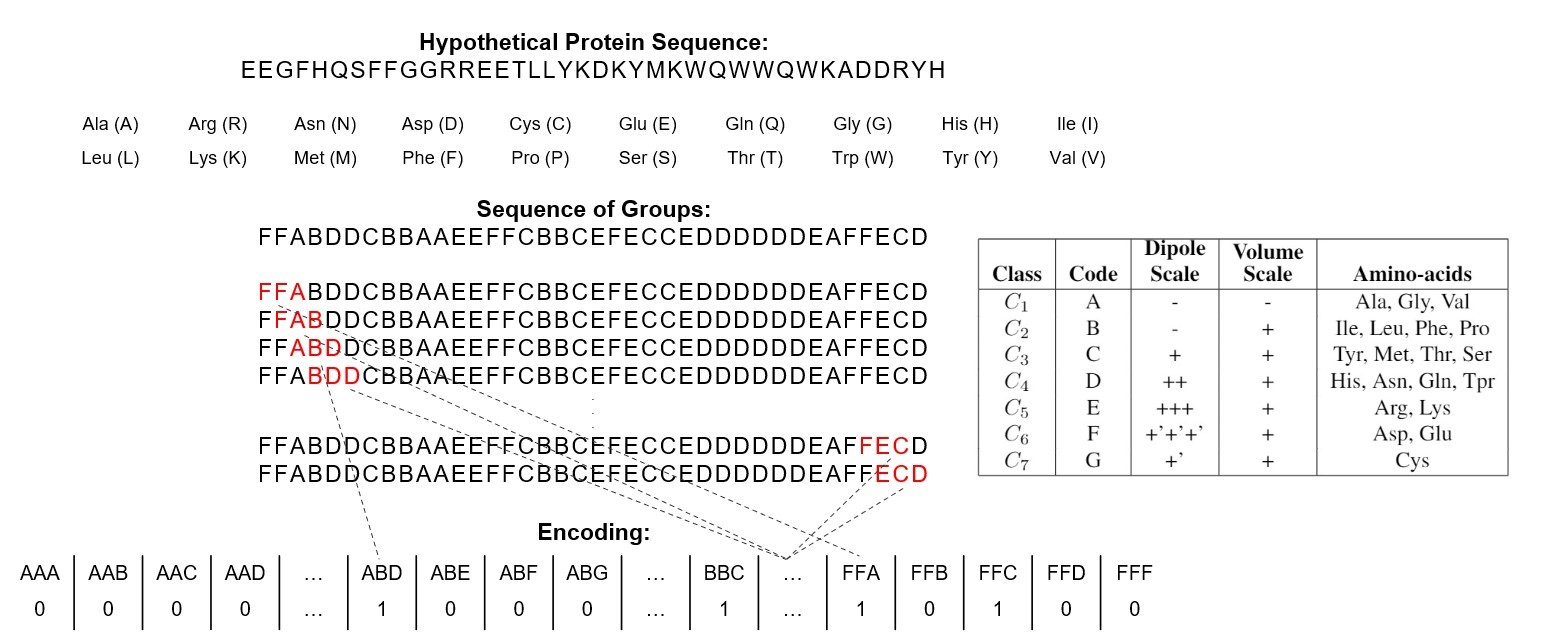

In [22]:
drug_encoding, target_encoding = 'MPNN', 'Conjoint_triad'

We need to further process the data before training by splitting it into **training**, **validation**, and **test** sets, and applying the encodings. Here we use a *random* split, which resembles a shuffle and the ratios are 0.7 for training; 0.1 for validation and 0.2 for test sets. A random seed is defined for reproducibility. A random seed ensures that the data is splitted exactly the same way in each run of the code. If we do not give it a random seed, then each run would produce different splits from the same data.

In [23]:
train, val, test = utils.data_process(X_drugs, X_targets, y,
                                drug_encoding, target_encoding,
                                split_method='random',frac=[0.7,0.1,0.2],
                                random_seed = 1)

train.head(1)

Drug Target Interaction Prediction Mode...
in total: 118254 drug-target pairs
encoding drug...
unique drugs: 2068
encoding protein...
unique target sequence: 229
splitting dataset...
Done.


,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...,11.1,"[[[tensor(1.), tensor(0.), tensor(0.), tensor(...","[1, 3, 0, 0, 3, 3, 0, 3, 9, 6, 6, 0, 2, 1, 4, ..."


In [24]:
config = utils.generate_config(drug_encoding = drug_encoding,
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512],
                         train_epoch = 5,
                         LR = 0.001,
                         batch_size = 128,
                         hidden_dim_drug = 128,
                         mpnn_hidden_size = 128,
                         mpnn_depth = 3
                        )

After we defined the configurations for our model, we initialize the model and start the training.

Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 139.012. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 1.80748. Total time 0.00194 hours
Training at Epoch 1 iteration 200 with loss 0.69984. Total time 0.00388 hours
Training at Epoch 1 iteration 300 with loss 0.93697. Total time 0.00611 hours
Training at Epoch 1 iteration 400 with loss 1.02960. Total time 0.00805 hours
Training at Epoch 1 iteration 500 with loss 0.99624. Total time 0.01027 hours
Training at Epoch 1 iteration 600 with loss 1.08259. Total time 0.01222 hours
Validation at Epoch 1 with loss:0.83245, MSE: 0.63242 , Pearson Correlation: 0.32636 with p-value: 1.60E-291 , Concordance Index: 0.66047
Training at Epoch 2 iteration 0 with loss 0.66843. Total time 0.01388 hours
Training at Epoch 2 iteration 100 with loss 0.63808. Total time 0.01583 hours
Training at Epoch 2 iteration 200 with loss 0.86464. Total time 0.01805 hours
Training at Epoch 2 iter

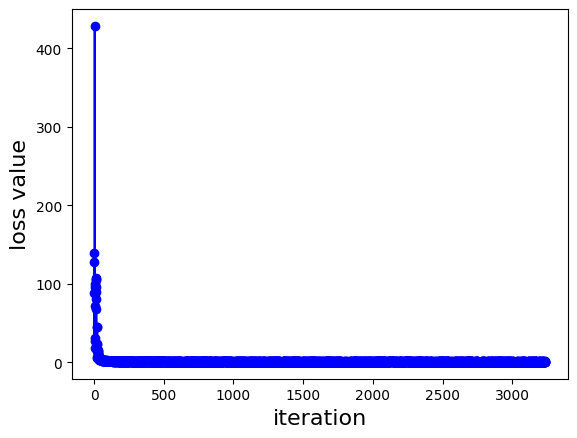

In [25]:
model = models.model_initialize(**config)
model.train(train, val, test)

It is not a bad idea to save a model after the training is complete. To save a model:

In [26]:
model.save_model('./virtualscreening_model_100epochs')

To load a saved/pretrained model:

In [27]:
model = models.model_pretrained(path_dir = 'virtualscreening_model_100epochs')

We have trained our model, let's move on to virtual screening to find possible antiviral drug candidates for our target molecule, ***RdRp***.

SARS-CoV-2 has 17 proteins synthesised from its genome. Thr **RdRp** region is located between positions 4393-5324 on *Replicase polyprotein 1ab*. For more detailed information and the sequence you can visit Uniprot: [Uniprot Entry for Replicase polyprotein 1ab](https://www.uniprot.org/uniprot/P0DTD1#PRO_0000449629)

In [28]:
t = "SADAQSFLNRVCGVSAARLTPCGTGTSTDVVYRAFDIYNDKVAGFAKFLKTNCCRFQEKDEDDNLIDSYFVVKRHTFSNYQHEETIYNLLKDCPAVAKHDFFKFRIDGDMVPHISRQRLTKYTMADLVYALRHFDEGNCDTLKEILVTYNCCDDDYFNKKDWYDFVENPDILRVYANLGERVRQALLKTVQFCDAMRNAGIVGVLTLDNQDLNGNWYDFGDFIQTTPGSGVPVVDSYYSLLMPILTLTRALTAESHVDTDLTKPYIKWDLLKYDFTEERLKLFDRYFKYWDQTYHPNCVNCLDDRCILHCANFNVLFSTVFPPTSFGPLVRKIFVDGVPFVVSTGYHFRELGVVHNQDVNLHSSRLSFKELLVYAADPAMHAASGNLLLDKRTTCFSVAALTNNVAFQTVKPGNFNKDFYDFAVSKGFFKEGSSVELKHFFFAQDGNAAISDYDYYRYNLPTMCDIRQLLFVVEVVDKYFDCYDGGCINANQVIVNNLDKSAGFPFNKWGKARLYYDSMSYEDQDALFAYTKRNVIPTITQMNLKYAISAKNRARTVAGVSICSTMTNRQFHQKLLKSIAATRGATVVIGTSKFYGGWHNMLKTVYSDVENPHLMGWDYPKCDRAMPNMLRIMASLVLARKHTTCCSLSHRFYRLANECAQVLSEMVMCGGSLYVKPGGTSSGDATTAYANSVFNICQAVTANVNALLSTDGNKIADKYVRNLQHRLYECLYRNRDVDTDFVNEFYAYLRKHFSMMILSDDAVVCFNSTYASQGLVASIKNFKSVLYYQNNVFMSEAKCWTETDLTKGPHEFCSQHTMLVKQGDDYVYLPYPDPSRILGAGCFVDDIVKTDGTLMIERFVSLAIDAYPLTKHPNQEYADVFHLYLQYIRKLHDELTGHMLDMYSVMLTNDNTSRYWEPEFYEAMYTPHTVLQ"
t_name = "RNA-Dependent RNA Polymerase SARS CoV-2"

print('Target Name: ' + t_name)
print('Amino Acid Sequence: '+ t)

Target Name: RNA-Dependent RNA Polymerase SARS CoV-2
Amino Acid Sequence: SADAQSFLNRVCGVSAARLTPCGTGTSTDVVYRAFDIYNDKVAGFAKFLKTNCCRFQEKDEDDNLIDSYFVVKRHTFSNYQHEETIYNLLKDCPAVAKHDFFKFRIDGDMVPHISRQRLTKYTMADLVYALRHFDEGNCDTLKEILVTYNCCDDDYFNKKDWYDFVENPDILRVYANLGERVRQALLKTVQFCDAMRNAGIVGVLTLDNQDLNGNWYDFGDFIQTTPGSGVPVVDSYYSLLMPILTLTRALTAESHVDTDLTKPYIKWDLLKYDFTEERLKLFDRYFKYWDQTYHPNCVNCLDDRCILHCANFNVLFSTVFPPTSFGPLVRKIFVDGVPFVVSTGYHFRELGVVHNQDVNLHSSRLSFKELLVYAADPAMHAASGNLLLDKRTTCFSVAALTNNVAFQTVKPGNFNKDFYDFAVSKGFFKEGSSVELKHFFFAQDGNAAISDYDYYRYNLPTMCDIRQLLFVVEVVDKYFDCYDGGCINANQVIVNNLDKSAGFPFNKWGKARLYYDSMSYEDQDALFAYTKRNVIPTITQMNLKYAISAKNRARTVAGVSICSTMTNRQFHQKLLKSIAATRGATVVIGTSKFYGGWHNMLKTVYSDVENPHLMGWDYPKCDRAMPNMLRIMASLVLARKHTTCCSLSHRFYRLANECAQVLSEMVMCGGSLYVKPGGTSSGDATTAYANSVFNICQAVTANVNALLSTDGNKIADKYVRNLQHRLYECLYRNRDVDTDFVNEFYAYLRKHFSMMILSDDAVVCFNSTYASQGLVASIKNFKSVLYYQNNVFMSEAKCWTETDLTKGPHEFCSQHTMLVKQGDDYVYLPYPDPSRILGAGCFVDDIVKTDGTLMIERFVSLAIDAYPLTKHPNQEYADVFHLYLQYIRKLHDELTGHMLDMYSVMLTNDNTSRYWEPEFYEAMYT

Let's visualize the target protein. It is a 3 chain protein complex, chains are A, B, and C.

In [29]:
view = py3Dmol.view(query='pdb:7bv2', options={'doAssembly':True})
chA = {'chain':'A'}
chB = {'chain':'B'}
chC = {'chain':'C'}
view.setStyle({'stick':{}})
view.setStyle(chA, {'cartoon': {'color':'red'}})
view.setStyle(chB, {'cartoon': {'color':'blue'}})
view.setStyle(chC, {'cartoon': {'color':'green'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'red'}, chA)
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'blue'}, chB)
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'green'}, chC)

view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

The dataset in the [link](https://dataverse.harvard.edu/file.xhtml?fileId=4159652) contains information on antiviral drugs. We will first download this dataset, and then read it into a Pandas dataframe for the drug repurposing task. Here the aim is to predict binding affinities of each of these drugs with *RdRp* and identify some drug repurposing candidates from already available antiviral drugs.

In [30]:
path = './data'
url = 'https://dataverse.harvard.edu/api/access/datafile/4159652'
download_path = os.path.join(path, 'antiviral_drugs.tab')
r = requests.get(url, allow_redirects=True)
open(download_path, 'wb').write(r.content)
antiviral_drugs_df = pd.read_csv(download_path, sep = '\t')

print("Number of Antiviral Drugs:", len(antiviral_drugs_df))

Number of Antiviral Drugs: 82


Construct the Pandas DF from the downloaded data.

In [31]:
r, r_name, r_pubchem_cid = antiviral_drugs_df.SMILES.values, antiviral_drugs_df[' Name'].values, antiviral_drugs_df['Pubchem CID'].values
print('Repurposing Drug 1 Name: ' + r_name[0])
print('Repurposing Drug 1 SMILES: ' + r[0])
print('Repurposing Drug 1 Pubchem CID: ' + str(r_pubchem_cid[0]))

Repurposing Drug 1 Name: Abacavir
Repurposing Drug 1 SMILES: C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C=C4)CO
Repurposing Drug 1 Pubchem CID: 441300


Let's see the structure of this drug molecule.

In [32]:
mol = Chem.MolFromSmiles(r[0])
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol, maxIters=200)

mblock = Chem.MolToMolBlock(mol)
view = py3Dmol.view()
view.addModel(mblock, 'mol')
view.setStyle({'stick':{}})
view.zoomTo()

view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Let us try a single drug prediction. We know that Remdesivir is an actively used drug for the treatment of SARS-CoV-2. It is originally developed for the treatment of Ebola, but drug repurposing studies showed that it may be effective for SARS-CoV-2 as well.

In [33]:
X_drug = antiviral_drugs_df[antiviral_drugs_df[' Name'] == 'Remdesivir'].SMILES.values
X_target = t
y = [1000]

In [34]:
X_pred = utils.data_process(X_drug, X_target, y,
                                drug_encoding, target_encoding,
                                split_method='no_split')

y_pred = model.predict(X_pred)
print('The predicted score is ' + str(y_pred))

Drug Target Interaction Prediction Mode...
in total: 1 drug-target pairs
encoding drug...
unique drugs: 1
encoding protein...
unique target sequence: 1
splitting dataset...
do not do train/test split on the data for already splitted data
predicting...
The predicted score is [11.556731224060059]


This one-liner is a courtesy of DeepPurpose. It uses the model we trained before, and predict the binding score for each drug with a given target. Here, we give the antiviral drug dataset for prediction, and our target is the sequence of *RdRp*.

In [35]:
y_pred = models.repurpose(X_repurpose = r, target = t, model = model, drug_names = r_name, target_name = t_name,
                          result_folder = ".")

repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Drug Repurposing Result for RNA-Dependent RNA Polymerase SARS CoV-2
+------+----------------------+-----------------------------------------+---------------+
| Rank |      Drug Name       |               Target Name               | Binding Score |
+------+----------------------+-----------------------------------------+---------------+
|  1   |      Amantadine      | RNA-Dependent RNA Polymerase SARS CoV-2 |     12.09     |
|  2   |      Nevirapine      | RNA-Dependent RNA Polymerase SARS CoV-2 |     12.03     |
|  3   |      Tenofovir       | RNA-Dependent RNA Polymerase SARS CoV-2 |     11.99     |
|  4   |      Lamivudine      | RNA-Dependent RNA Polymerase SARS CoV-2 |     11.97     |
|  5   |      Etravirine      | RNA-Dependent RNA Polymerase SARS CoV-2 |     11.95     |
|  6   

#Assessment Questions

1. Find the best drug-target pair (with highest prediction score) found by our CNN model in the test set.

  a. Visualize drug molecule.
  
  b. Find possible drugs for the protein molecule using DeepPurpose.

In [36]:
### Your code here

2. SARS-CoV2 3CL Protease is another drug target for
COVID-19. Try the same drug repurposing function for 3CL Protease.

Hint: Sequence for SARS-CoV2 3CL Protease: SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ

In [37]:
### Your code here